In [1]:
from signal_utils import *

## Test Signal

Fmax = 0.425


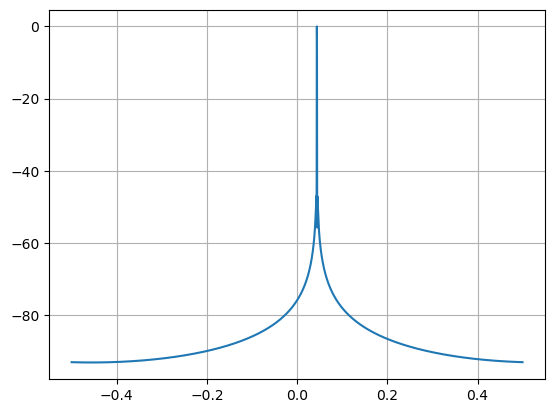

In [2]:
N = 2**12
n = np.arange(N)

perc = 0.15
Fmax = 0.5 * (1 - perc)
print(f"Fmax = {Fmax}")

F = 0.35/8

x = 1.0 * np.exp(1j * 2*np.pi*F*n)
xr = x.real
xi = x.imag

plotdB(x, True)

## Delay Filter

In [56]:
AdB_delay = 80
deltaPass = 10**(-AdB_delay/20)
deltaStop = deltaPass

I = 4
Fpass = Fmax / I
Fstop = (1 - Fmax) / I

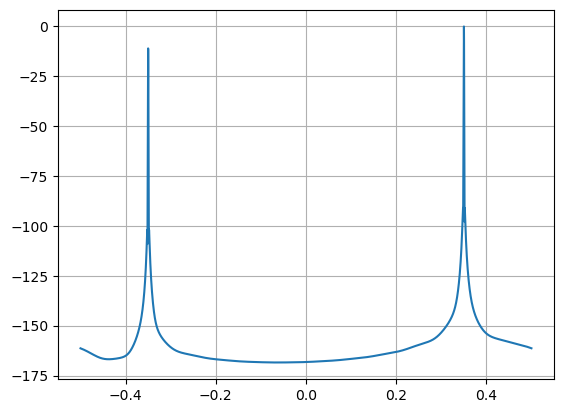

In [57]:
firCoeff = remezlp(Fpass, Fstop, deltaPass, deltaStop, even_n = False, nPoints=N, Nmax=N)
polyFirCoeff = makePolyphase(firCoeff, I)
commonDelay = int((len(firCoeff) - 1) / I / 2)

xr_delay = signal.lfilter(polyFirCoeff[-2], 1.0, xr)
xi_delay = signal.lfilter(polyFirCoeff[-1], 1.0, xi)
x_delay = xr_delay + 1j*xi_delay

freqs, xfft, angle = fftdB(x_delay)
plt.plot(freqs, xfft)
plt.grid()
plt.show();

## Delta-Sigma Modulation (from cpp)

In [5]:
quant_type = "mid-tread"

# Path to C++ executable
cpp_path = "../build/delta-sigma"
xr_in_path = "./data/serial/xr_in.txt"
xi_in_path = "./data/serial/xi_in.txt"
xr_out_path = "./data/serial/xr_out.txt"
xi_out_path = "./data/serial/xi_out.txt"
iir_path = "../data/input/deltaSigma_iirs.txt"

In [6]:
xr_in = [xr, xr_delay]
xi_in = [xi, xi_delay]

In [7]:
xr_deltaSigma = []
xi_deltaSigma = []
x_deltaSigma = []

for xr_i,xi_i in zip(xr_in, xi_in):
    tmp = 4/np.max(xr_i)
    xr_input = np.array(xr_i) * tmp
    xi_input = np.array(xi_i) * tmp
    
    np.savetxt(xr_in_path, xr_input, fmt="%.18e")
    np.savetxt(xi_in_path, xi_input, fmt="%.18e")
    
    # Call the C++ program with input and output file paths as arguments
    subprocess.run([cpp_path, xr_in_path, xi_in_path, xr_out_path, xi_out_path, iir_path, quant_type])
    
    xr_deltaSigma_tmp = np.round(np.loadtxt(xr_out_path))
    xi_deltaSigma_tmp = np.round(np.loadtxt(xi_out_path))
    x_deltaSigma_tmp = xr_deltaSigma_tmp + 1j*xi_deltaSigma_tmp

    xr_deltaSigma.append(xr_deltaSigma_tmp)
    xi_deltaSigma.append(xi_deltaSigma_tmp)
    x_deltaSigma.append(x_deltaSigma_tmp)

File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt
File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt


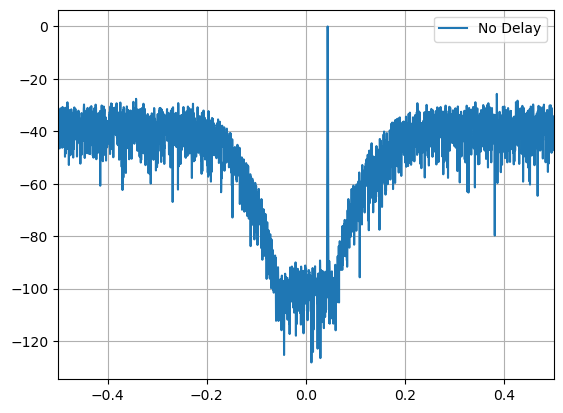

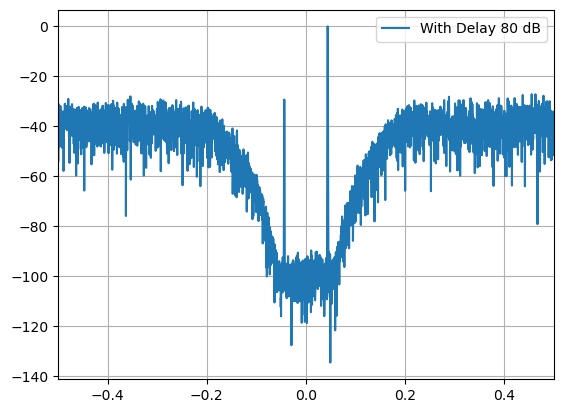

In [8]:
labels=["No Delay", f"With Delay {AdB_delay} dB"]

for x_i,label_i in zip(x_deltaSigma, labels):
    freqs_i, xfftdB_i, angle_i = fftdB(x_i)
    xmin = -0.5
    xmax = 0.5
    plt.plot(freqs_i, xfftdB_i, label=label_i)
    plt.legend()
    plt.xlim([xmin, xmax])
    plt.grid()
    plt.show();

## RFIQ Filter

In [9]:
NyqZones = 4

x_rfiq = []
for xrfiq_in in x_deltaSigma:
    x_rfiq.append(rfiq_filter(xrfiq_in, NyqZones))

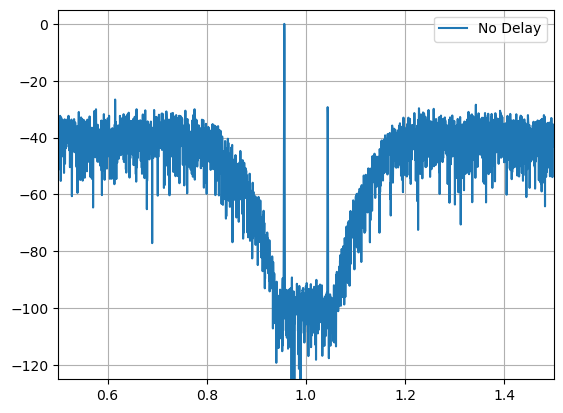

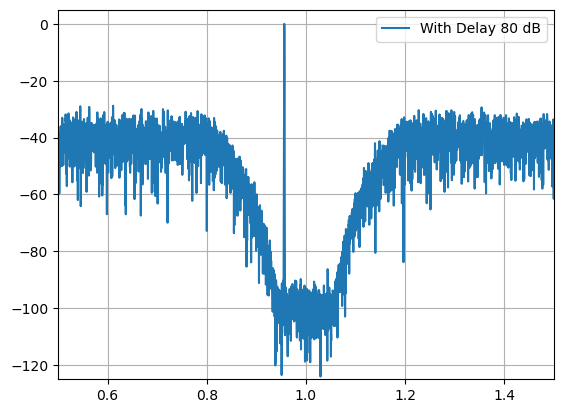

In [10]:
labels=["No Delay", f"With Delay {AdB_delay} dB"]

for x_i,label_i in zip(x_rfiq, labels):
    freqs_i, xfftdB_i, angle_i = fftdB(x_i)
    freqs_i *= NyqZones
    xmin = 1-0.5
    xmax = 1+0.5
    plt.plot(freqs_i, xfftdB_i, label=label_i)
    plt.legend()
    plt.xlim([xmin, xmax])
    plt.ylim([-125, 5])
    plt.grid()
    plt.show();

# With Interpolation After the Delay

Fmax = 0.425


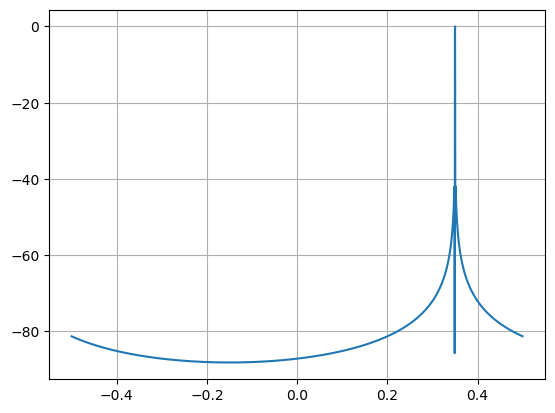

In [43]:
N = 2**12
n = np.arange(N)

perc = 0.15
Fmax = 0.5 * (1 - perc)
print(f"Fmax = {Fmax}")

F = 0.35

x = 1.0 * np.exp(1j * 2*np.pi*F*n)
xr = x.real
xi = x.imag

plotdB(x, True)

## Delay Filter

In [44]:
AdB_delay = 40
deltaPass = 10**(-AdB_delay/20)
deltaStop = deltaPass

I = 4*15
Fpass = Fmax / I
Fstop = (1 - Fmax) / I

781


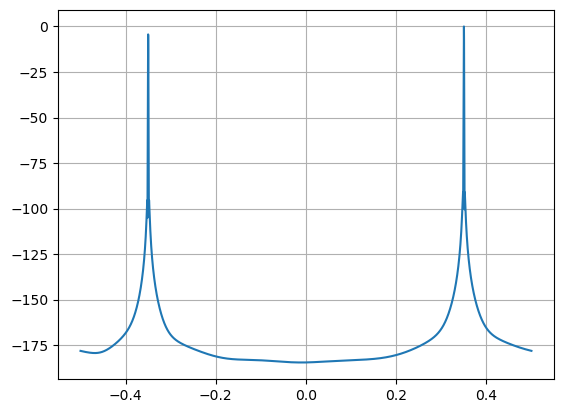

In [45]:
firCoeff = remezlp(Fpass, Fstop, deltaPass, deltaStop, even_n = False, nPoints=N, Nmax=N)
print(len(firCoeff))
polyFirCoeff = makePolyphase(firCoeff, I)
commonDelay = int((len(firCoeff) - 1) / I / 2)

xr_delay = signal.lfilter(polyFirCoeff[len(polyFirCoeff)//2-1], 1.0, xr)
xi_delay = signal.lfilter(polyFirCoeff[-1], 1.0, xi)
x_delay = xr_delay + 1j*xi_delay

freqs, xfft, angle = fftdB(x_delay)
plt.plot(freqs, xfft)
plt.grid()
plt.show();

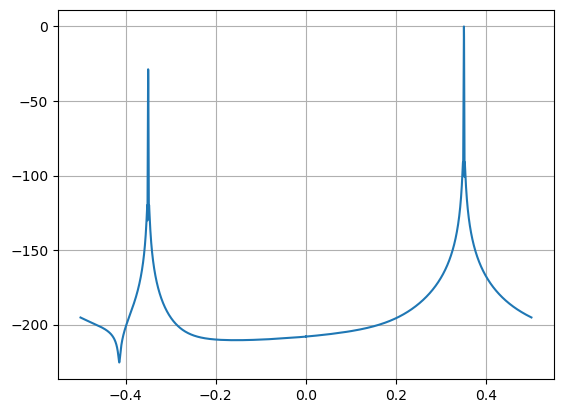

In [67]:
delta_r = 1/2/8
delta_i = 1/4/8
xr_delay = firrow_filter(xr, delta_r)
xi_delay = firrow_filter(xi, delta_i)
x_delay = xr_delay + 1j*xi_delay


freqs, xfft, angle = fftdB(x_delay)
plt.plot(freqs, xfft)
plt.grid()
plt.show();

## Interpolation

In [68]:
AdB_interpolation = 80
deltaPass = 10**(-AdB_interpolation/20)
deltaStop = deltaPass

OSR = 8
F = [Fmax, 1-Fmax]
delta = [deltaPass, deltaStop]

# Interpolation by a factor of 8
xr_osr8 = np.real(interpolate(xr_delay, OSR, F, delta, show=False, prt=False))
xi_osr8 = np.real(interpolate(xi_delay, OSR, F, delta, show=False, prt=False))
x_osr8 = xr_osr8 + 1j*xi_osr8

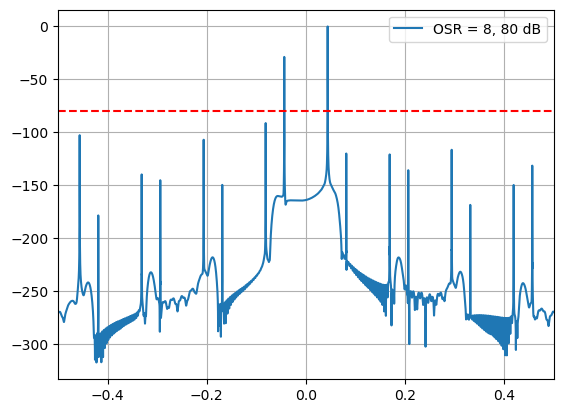

In [69]:
freqs_osr8, xfftdB_osr8, angle_osr8 = fftdB(x_osr8)
xmin = -0.5
xmax = 0.5
plt.plot(freqs_osr8, xfftdB_osr8, label=f"OSR = {OSR}, {AdB_interpolation} dB")
plt.plot([xmin, xmax], [-AdB_interpolation, -AdB_interpolation], '--r')
plt.legend()
plt.xlim([xmin, xmax])
plt.grid()
plt.show();

## Delta-Sigma Modulation (from cpp)

In [70]:
quant_type = "mid-tread"

# Path to C++ executable
cpp_path = "../build/delta-sigma"
xr_in_path = "./data/serial/xr_in.txt"
xi_in_path = "./data/serial/xi_in.txt"
xr_out_path = "./data/serial/xr_out.txt"
xi_out_path = "./data/serial/xi_out.txt"
iir_path = "../data/input/deltaSigma_iirs.txt"

In [71]:
xr_in = [xr, xr_delay, xr_osr8]
xi_in = [xi, xi_delay, xi_osr8]

In [72]:
xr_deltaSigma = []
xi_deltaSigma = []
x_deltaSigma = []

for xr_i,xi_i in zip(xr_in, xi_in):
    tmp = 4/np.max(xr_i)
    xr_input = np.array(xr_i) * tmp
    xi_input = np.array(xi_i) * tmp
    
    np.savetxt(xr_in_path, xr_input, fmt="%.18e")
    np.savetxt(xi_in_path, xi_input, fmt="%.18e")
    
    # Call the C++ program with input and output file paths as arguments
    subprocess.run([cpp_path, xr_in_path, xi_in_path, xr_out_path, xi_out_path, iir_path, quant_type])
    
    xr_deltaSigma_tmp = np.round(np.loadtxt(xr_out_path))
    xi_deltaSigma_tmp = np.round(np.loadtxt(xi_out_path))
    x_deltaSigma_tmp = xr_deltaSigma_tmp + 1j*xi_deltaSigma_tmp

    xr_deltaSigma.append(xr_deltaSigma_tmp)
    xi_deltaSigma.append(xi_deltaSigma_tmp)
    x_deltaSigma.append(x_deltaSigma_tmp)

File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt
File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt
File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt


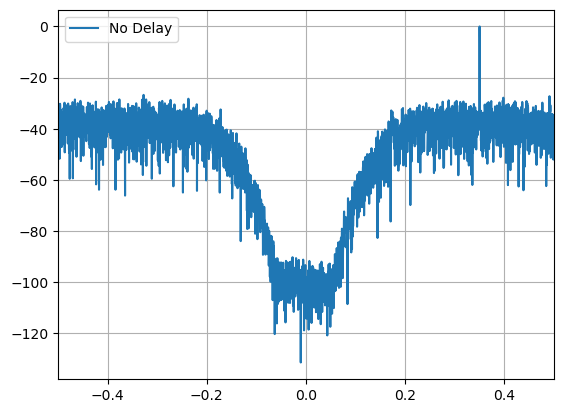

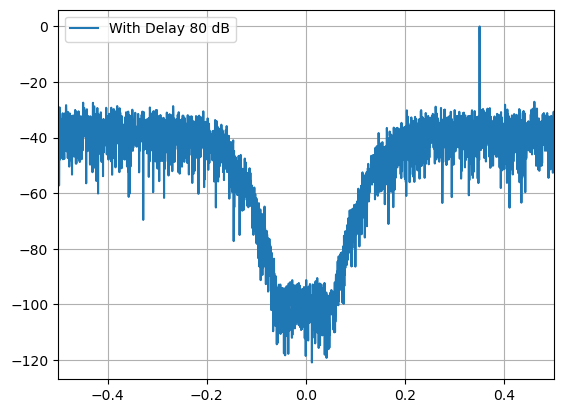

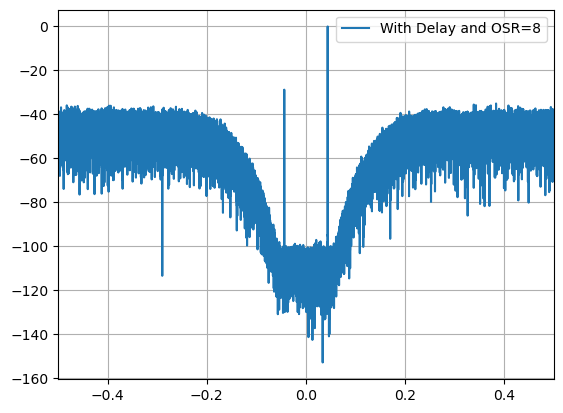

In [73]:
labels=["No Delay", f"With Delay {AdB_delay} dB", f"With Delay and OSR={OSR}"]

for x_i,label_i in zip(x_deltaSigma, labels):
    freqs_i, xfftdB_i, angle_i = fftdB(x_i)
    xmin = -0.5
    xmax = 0.5
    plt.plot(freqs_i, xfftdB_i, label=label_i)
    plt.legend()
    plt.xlim([xmin, xmax])
    plt.grid()
    plt.show();

## RFIQ Filter

In [74]:
NyqZones = 4

x_rfiq = []
for xrfiq_in in x_deltaSigma:
    x_rfiq.append(rfiq_filter(xrfiq_in, NyqZones))

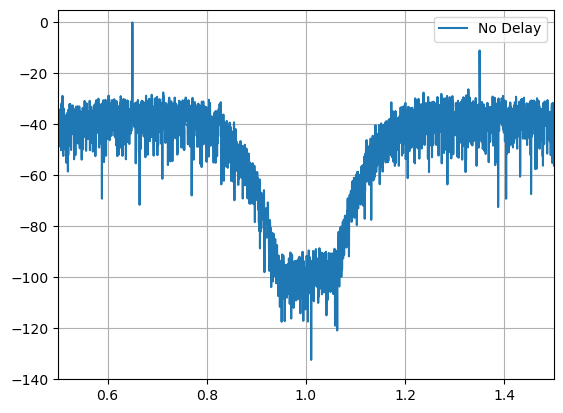

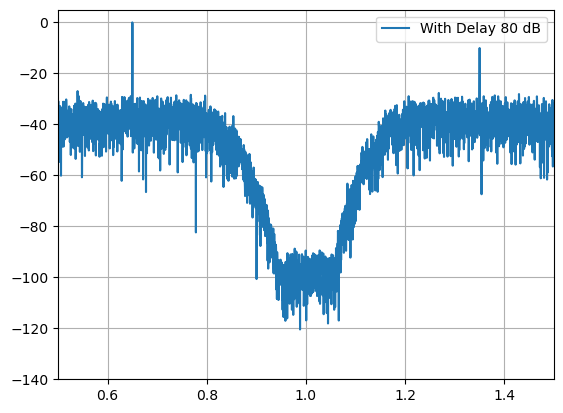

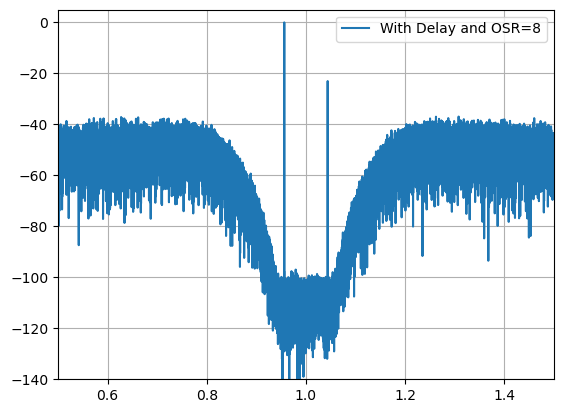

In [75]:
labels=["No Delay", f"With Delay {AdB_delay} dB", f"With Delay and OSR={OSR}"]

for x_i,label_i in zip(x_rfiq, labels):
    freqs_i, xfftdB_i, angle_i = fftdB(x_i)
    freqs_i *= NyqZones
    xmin = 1-0.5
    xmax = 1+0.5
    plt.plot(freqs_i, xfftdB_i, label=label_i)
    plt.legend()
    plt.xlim([xmin, xmax])
    plt.ylim([-140, 5])
    plt.grid()
    plt.show();

# With Interpolation Before the Delay

Fmax = 0.425


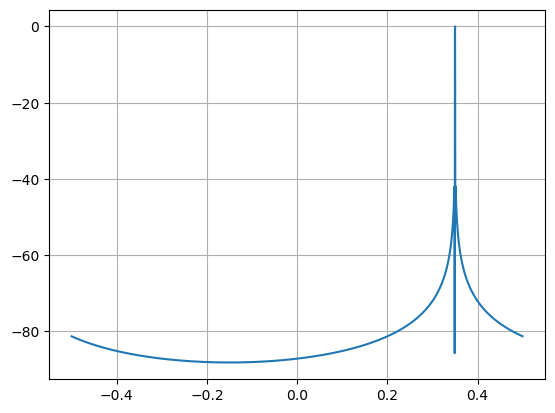

In [149]:
N = 2**12
n = np.arange(N)

perc = 0.15
Fmax = 0.5 * (1 - perc)
print(f"Fmax = {Fmax}")

F = 0.35

x = 1.0 * np.exp(1j * 2*np.pi*F*n)
xr = x.real
xi = x.imag

plotdB(x, True)

## Interpolation

In [150]:
AdB_interpolation = 80
deltaPass = 10**(-AdB_interpolation/20)
deltaStop = deltaPass

OSR = 8
F = [Fmax, 1-Fmax]
delta = [deltaPass, deltaStop]

# Interpolation by a factor of 8
xr_osr8 = np.real(interpolate(xr, OSR, F, delta, show=False, prt=False))
xi_osr8 = np.real(interpolate(xi, OSR, F, delta, show=False, prt=False))
x_osr8 = xr_osr8 + 1j*xi_osr8

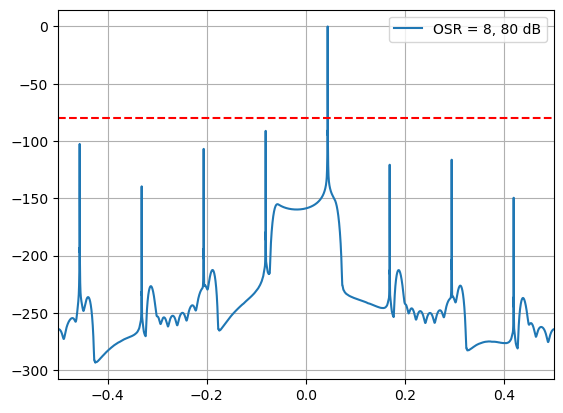

In [151]:
freqs_osr8, xfftdB_osr8, angle_osr8 = fftdB(x_osr8)
xmin = -0.5
xmax = 0.5
plt.plot(freqs_osr8, xfftdB_osr8, label=f"OSR = {OSR}, {AdB_interpolation} dB")
plt.plot([xmin, xmax], [-AdB_interpolation, -AdB_interpolation], '--r')
plt.legend()
plt.xlim([xmin, xmax])
plt.grid()
plt.show();

## Delay Filter

In [152]:
AdB_delay = 80
deltaPass = 10**(-AdB_delay/20)
deltaStop = deltaPass

I = 4
Fpass = Fmax / I
Fstop = (1 - Fmax) / I

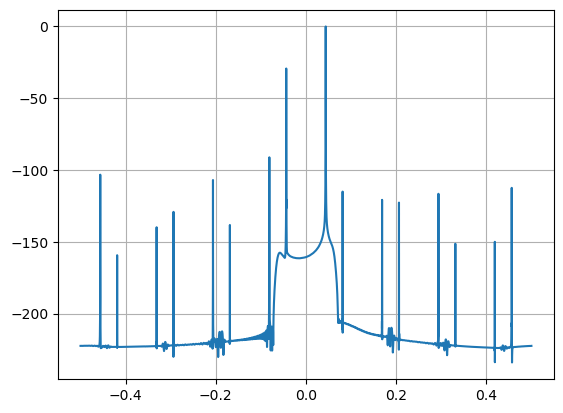

In [153]:
firCoeff = remezlp(Fpass, Fstop, deltaPass, deltaStop, even_n = False, nPoints=N, Nmax=N)
polyFirCoeff = makePolyphase(firCoeff, I)
commonDelay = int((len(firCoeff) - 1) / I / 2)

xr_delay = signal.lfilter(polyFirCoeff[-2], 1.0, xr_osr8)
xi_delay = signal.lfilter(polyFirCoeff[-1], 1.0, xi_osr8)
x_delay = xr_delay + 1j*xi_delay

freqs, xfft, angle = fftdB(x_delay)
plt.plot(freqs, xfft)
plt.grid()
plt.show();

## Delta-Sigma Modulation (from cpp)

In [154]:
quant_type = "mid-tread"

# Path to C++ executable
cpp_path = "../build/delta-sigma"
xr_in_path = "./data/serial/xr_in.txt"
xi_in_path = "./data/serial/xi_in.txt"
xr_out_path = "./data/serial/xr_out.txt"
xi_out_path = "./data/serial/xi_out.txt"
iir_path = "../data/input/deltaSigma_iirs.txt"

In [155]:
xr_in = [xr_delay]
xi_in = [xi_delay]

In [156]:
xr_deltaSigma = []
xi_deltaSigma = []
x_deltaSigma = []

for xr_i,xi_i in zip(xr_in, xi_in):
    tmp = 4/np.max(xr_i)
    xr_input = np.array(xr_i) * tmp
    xi_input = np.array(xi_i) * tmp
    
    np.savetxt(xr_in_path, xr_input, fmt="%.18e")
    np.savetxt(xi_in_path, xi_input, fmt="%.18e")
    
    # Call the C++ program with input and output file paths as arguments
    subprocess.run([cpp_path, xr_in_path, xi_in_path, xr_out_path, xi_out_path, iir_path, quant_type])
    
    xr_deltaSigma_tmp = np.round(np.loadtxt(xr_out_path))
    xi_deltaSigma_tmp = np.round(np.loadtxt(xi_out_path))
    x_deltaSigma_tmp = xr_deltaSigma_tmp + 1j*xi_deltaSigma_tmp

    xr_deltaSigma.append(xr_deltaSigma_tmp)
    xi_deltaSigma.append(xi_deltaSigma_tmp)
    x_deltaSigma.append(x_deltaSigma_tmp)

File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt


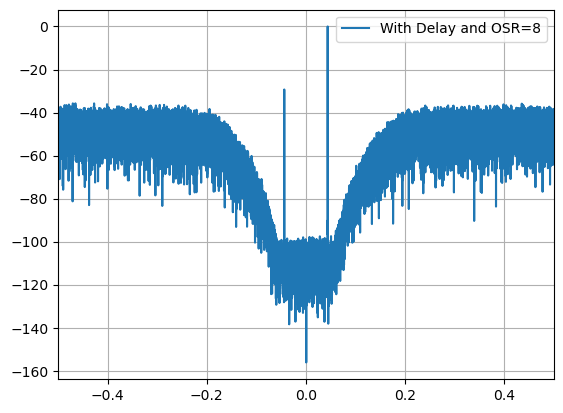

In [157]:
labels=[f"With Delay and OSR={OSR}"]

for x_i,label_i in zip(x_deltaSigma, labels):
    freqs_i, xfftdB_i, angle_i = fftdB(x_i)
    xmin = -0.5
    xmax = 0.5
    plt.plot(freqs_i, xfftdB_i, label=label_i)
    plt.legend()
    plt.xlim([xmin, xmax])
    plt.grid()
    plt.show();

## RFIQ Filter

In [162]:
NyqZones = 4

x_rfiq = []
for xrfiq_in in x_deltaSigma:
    x_rfiq.append(rfiq_filter(xrfiq_in, NyqZones))

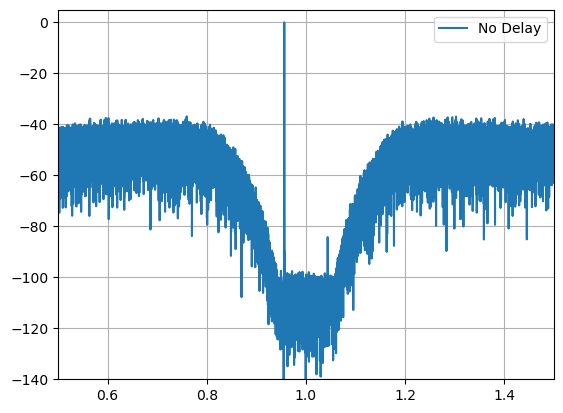

In [164]:
labels=["No Delay", f"With Delay {AdB_delay} dB", f"With Delay and OSR={OSR}"]

for x_i,label_i in zip(x_rfiq, labels):
    freqs_i, xfftdB_i, angle_i = fftdB(x_i)
    freqs_i *= NyqZones
    xmin = 1-0.5
    xmax = 1+0.5
    plt.plot(freqs_i, xfftdB_i, label=label_i)
    plt.legend()
    plt.xlim([xmin, xmax])
    plt.ylim([-140, 5])
    plt.grid()
    plt.show();